In [1]:
import time
#import space
import copy
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import numpy as np
import pandas as pd
import os
%matplotlib notebook
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes,mark_inset
from scipy.constants import c, h, physical_constants
from uncertainties import ufloat
from uncertainties import umath
from tqdm.notebook import tqdm
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
#sys.path.insert(1, '/Users/aidanmcconnell/Documents/PhD/FTIR_functions')

import ftir_interferrogram_functions as ftFuncs

import scipy
from scipy import signal
from scipy.optimize import curve_fit
from scipy.stats.distributions import t
import scipy.constants as const

from lmfit.models import ConstantModel, LorentzianModel, LinearModel
from lmfit.model import save_modelresult, load_modelresult
from lmfit.printfuncs import report_ci

############################# initialises some parameters for code #############################

# location of measurement files
parentDir = "E:/Theo_Silicon/"                                              ### adjust this for new experiment
measurementName = "2023-04-19-canopus"                                      ### adjust this for new experiment
sampleName = "3e14 cm-3 bulk doped Arsenic (Canopus)"                       ### adjust this for new experiment
path = os.path.join(parentDir, measurementName, "ASCII Files/") 

# location of reference scans
refScan1 = "2023-03-06-19-55-reference_scan-298K-measurements-opus"      ### adjust this for new experiment
refScan2 = "2023-03-10-16-20-reference_scan-299K-measurements-opus"      ### adjust this for new experiment
refPath1 = os.path.join(parentDir, refScan1, "ASCII Files/")
refPath2 = os.path.join(parentDir, refScan2, "ASCII Files/")


# creates new folder to store processed data
folderpath = os.path.join(parentDir, measurementName, "Processed data/")

if not os.path.isdir(folderpath):
    os.mkdir(folderpath)
    print('created new folder at ' + folderpath)
    
# creates new folder to store plots and results
resultspath = os.path.join(parentDir, measurementName, "results/")

if not os.path.isdir(resultspath):
    os.mkdir(resultspath)
    print('created new folder at ' + resultspath)
    
# names and location of processed reference data files    
nameReferenceData1Averaged = refScan1 + "_averaged.txt" 
nameReferenceData2Averaged = refScan2 + "_averaged.txt" 
pathReferenceData1Averaged = os.path.join(folderpath, nameReferenceData1Averaged)
pathReferenceData2Averaged = os.path.join(folderpath, nameReferenceData2Averaged)

# names and location of averaged data files
nameDataAveraged = measurementName + '_averaged.txt' 
pathDataAveraged = os.path.join(folderpath, nameDataAveraged)

# names and location of smoothed data files
nameDataSmoothed = measurementName + "_averagedAndSmoothed.txt"
pathDataSmoothed = os.path.join(folderpath, nameDataSmoothed)

# names of fourier transformed data files
nameDataRoughFt = measurementName + "_averaged_FT.txt"
pathDataRoughFt = os.path.join(folderpath, nameDataRoughFt)
nameDataSmoothFt = measurementName + "_averagedAndSmoothed_FT.txt"
pathDataSmoothFt = os.path.join(folderpath, nameDataSmoothFt)
nameRef1Ft = refScan1 + "_FT.txt"
pathRef1Ft = os.path.join(folderpath, nameRef1Ft)
nameRef2Ft = refScan2 + "_FT.txt"
pathRef2Ft = os.path.join(folderpath, nameRef2Ft)


print("Cell compiled at " + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

C:\Users\theow\Anaconda3\lib\site-packages\scipy\__init__.py:173: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.19.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Cell compiled at 2023-06-13 14:44:46


# This section has functions to help set up IFG


14 data sets processed


<IPython.core.display.Javascript object>


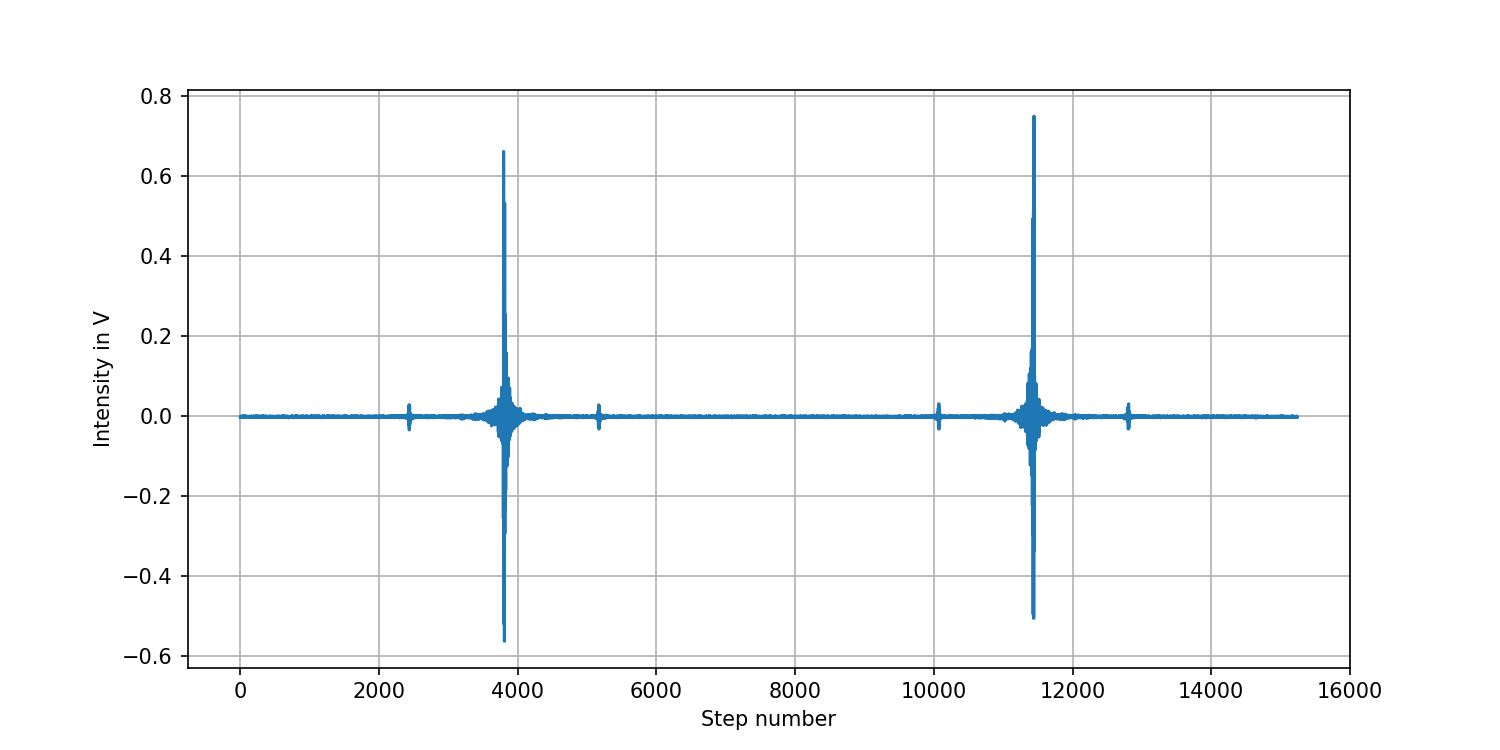

deleted old version of 2023-04-19-canopus_averaged.txt
saved file 2023-04-19-canopus_averaged.txt
Cell compiled at 2023-06-09 16:00:44


In [8]:
# averages data from txt files to single file
averaged_IFG = ftFuncs.average_IFGs_from_folder(path)
averaged_IFG["IFG Value"] *= 10

saveFigTo = os.path.join(resultspath, "IFG.png")
saveFigTo2 = os.path.join(resultspath, "IFG.eps")

plt.figure(figsize=(10, 5))
plt.plot(averaged_IFG["Step"], averaged_IFG["IFG Value"])
plt.xlabel("Step number")
plt.ylabel("Intensity in V")
plt.grid()
plt.savefig(saveFigTo)
plt.savefig(saveFigTo2)
plt.show()

# saves averaged data to txt file
if os.path.isfile(pathDataAveraged):
    os.remove(pathDataAveraged)
    print("deleted old version of " + nameDataAveraged)    

averaged_IFG.to_csv(pathDataAveraged, header=None, index=None, sep='\t', mode='a')
print("saved file " + nameDataAveraged)
print("Cell compiled at " + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

In [2]:
if ('averaged_IFG' in locals()):
    preProcessedAverage = averaged_IFG
else:
    preProcessedAverage = pd.read_csv(pathDataAveraged, sep="\t", header=None, names=["Step", "IFG Value"])

preProcessedAverage['Step'] = preProcessedAverage['Step'].astype(int)
    
#postProcessedAverage = ftFuncs.RemovedInternalReflections(preProcessedAverage.copy(), True, 50, 85, 1)

postProcessedAverage = preProcessedAverage.copy()
smoothingRegions = np.array([[2380, 2480], [5120, 5220], [10020, 10120], [12760, 12860]])
for i in range(smoothingRegions.shape[0]):
    smoothingRegion = smoothingRegions[i]
    postProcessedAverage = ftFuncs.removed_internal_reflections(postProcessedAverage, smoothingRegion)


# saves processed data as txt
if os.path.isfile(pathDataSmoothed):
    os.remove(pathDataSmoothed)
    print("deleted old version of " + nameDataSmoothed)   

postProcessedAverage.to_csv(pathDataSmoothed, header=None, index=None, sep='\t', mode='a')
print("saved file " + nameDataSmoothed)

print("Cell compiled at " + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))


Average noise level =  0.021835923566729323
85 % of data noise below:  0.005556385714285714
Cutoff at:  0.005556385714285714
Peak tolerance at: 0.016669157142857143


deleted old version of 2023-04-19-canopus_averagedAndSmoothed.txt
saved file 2023-04-19-canopus_averagedAndSmoothed.txt
Cell compiled at 2023-06-13 14:45:02


<IPython.core.display.Javascript object>


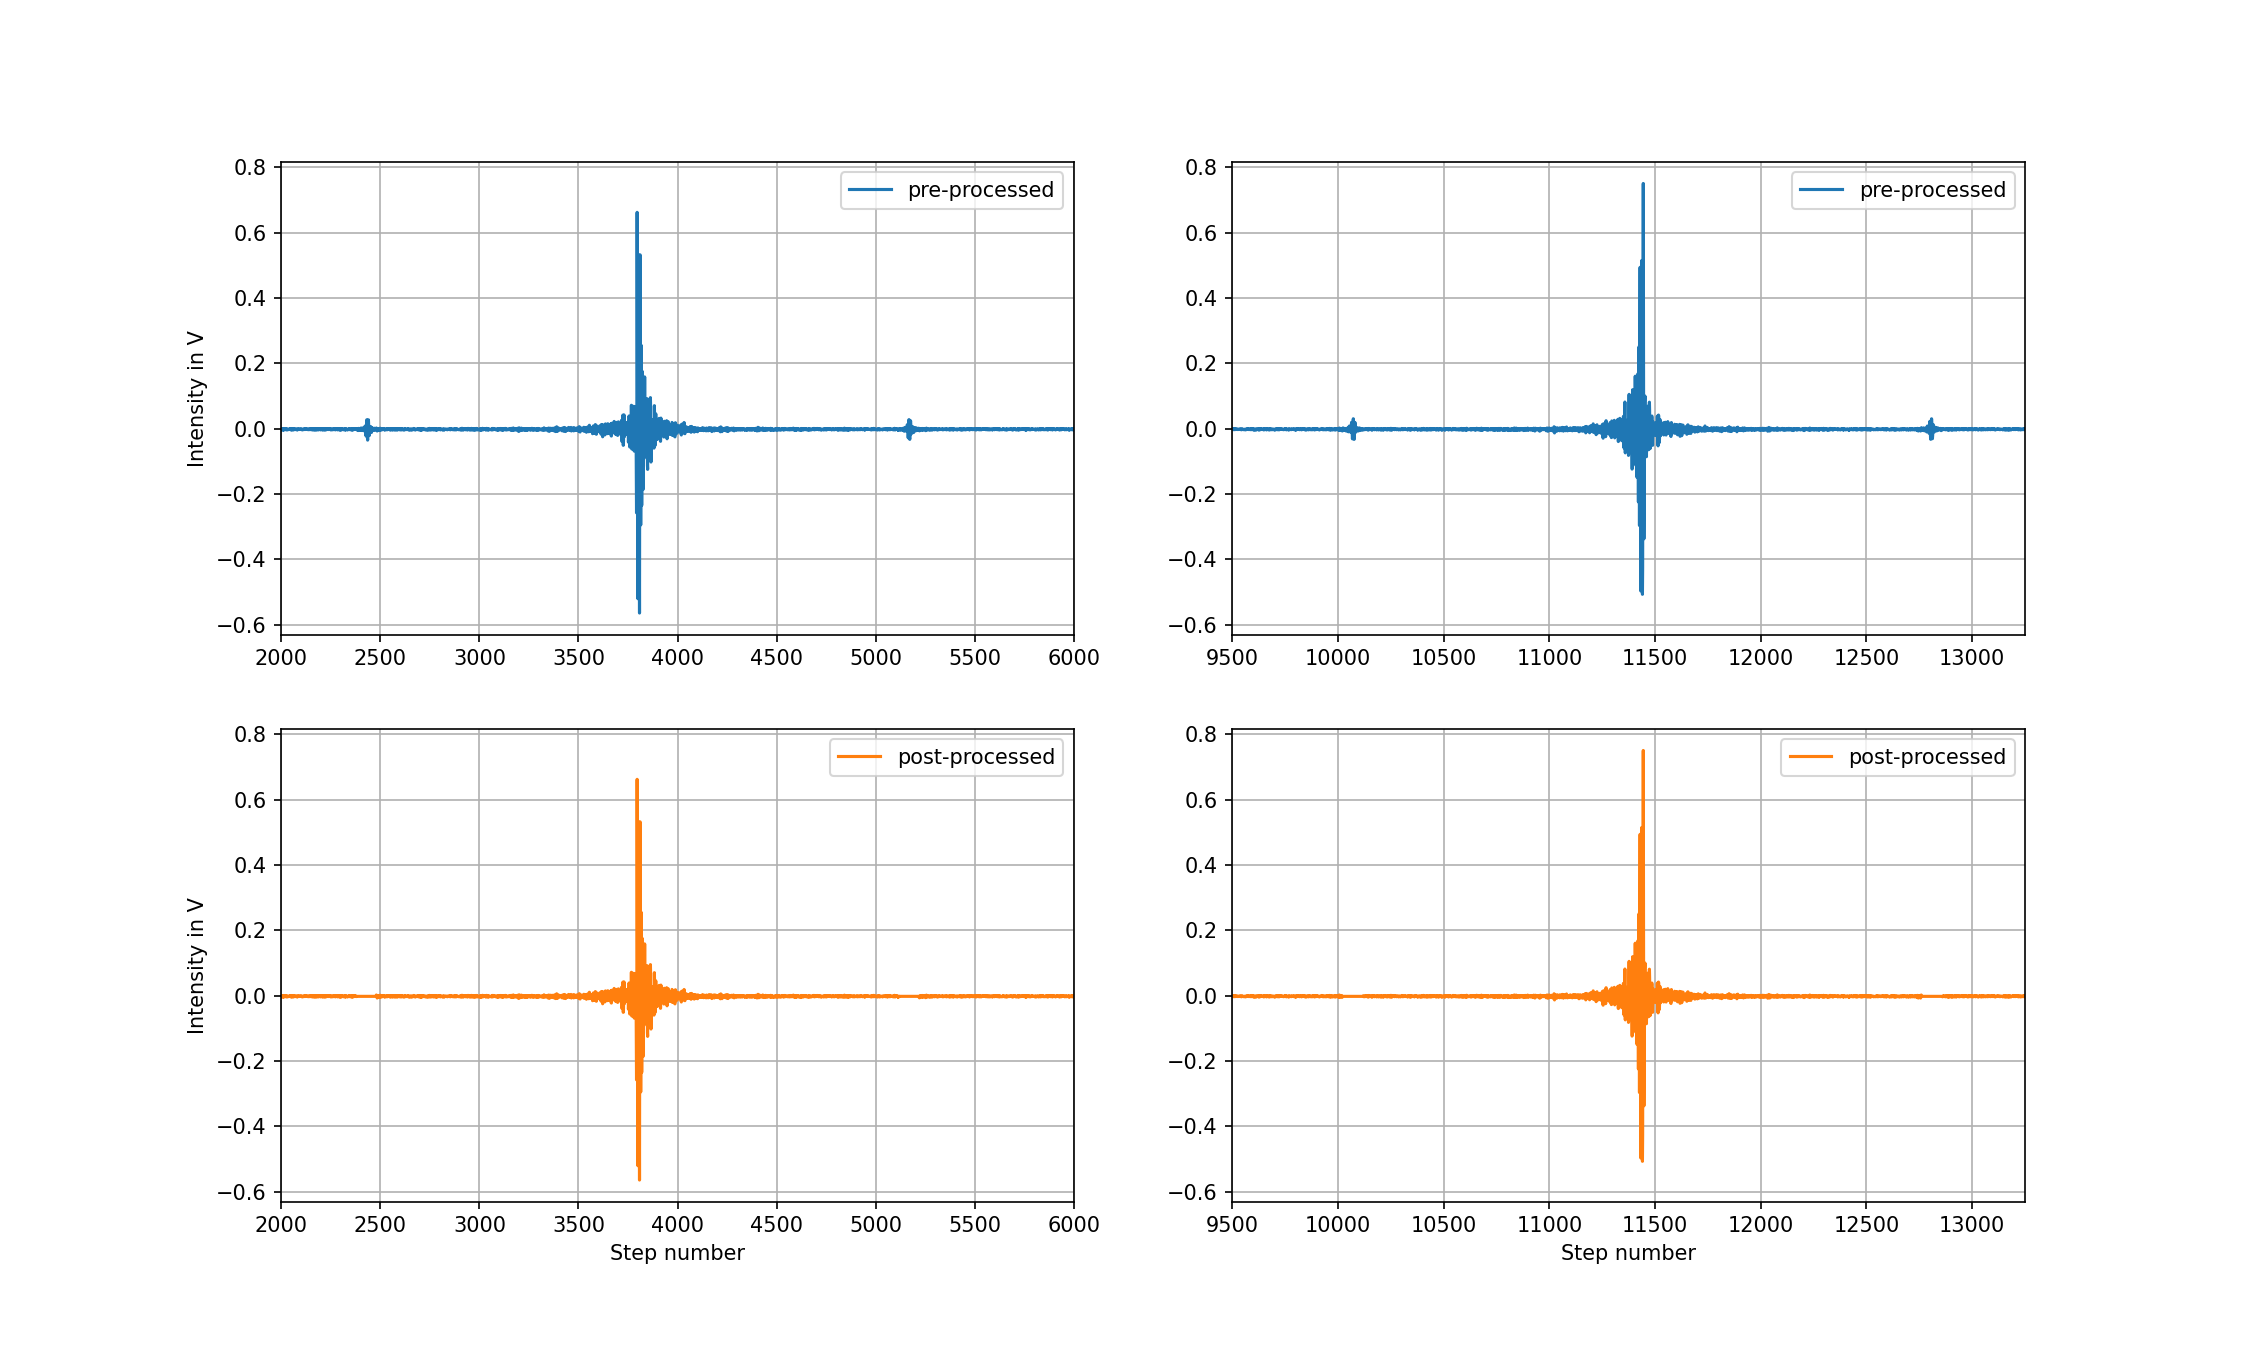

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Cell compiled at 2023-06-13 14:45:15


In [3]:
if not ('preProcessedAverage' in locals()):
    preProcessedAverage = pd.read_csv(pathDataAveraged, sep="\t", header=None, names=["Step", "IFG Value"])
if not ('postProcessedAverage' in locals()):
    postProcessedAverage = pd.read_csv(pathDataSmoothed, sep="\t", header=None, names=["Step", "IFG Value"])

    
saveFigTo = os.path.join(resultspath, "BeforeAndAfterSmoothing.png")
saveFigTo2 = os.path.join(resultspath, "BeforeAndAfterSmoothing.eps")

plotRange1 = [2000, 6000] # set range which to plot here
plotRange2 = [9500, 13250]

fig = plt.figure(figsize=(15, 9))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(223)
ax3 = fig.add_subplot(222)
ax4 = fig.add_subplot(224)
ax1.plot(preProcessedAverage["IFG Value"], label = "pre-processed", color = 'C0')
ax2.plot(postProcessedAverage["IFG Value"], label = "post-processed", color = 'C1')
ax3.plot(preProcessedAverage["IFG Value"], label = "pre-processed", color = 'C0')
ax4.plot(postProcessedAverage["IFG Value"], label = "post-processed", color = 'C1')
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax1.set_xlim(plotRange1)
ax2.set_xlim(plotRange1)
ax3.set_xlim(plotRange2)
ax4.set_xlim(plotRange2)
ax1.grid(axis='both', which='both')
ax2.grid(axis='both', which='both')
ax3.grid(axis='both', which='both')
ax4.grid(axis='both', which='both')
ax2.set_xlabel("Step number")
ax4.set_xlabel("Step number")
ax1.set_ylabel("Intensity in V")
ax2.set_ylabel("Intensity in V")
plt.savefig(saveFigTo)
plt.savefig(saveFigTo2)
plt.show()



print("Cell compiled at " + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

# Below we convert IFGs to spectra

<IPython.core.display.Javascript object>


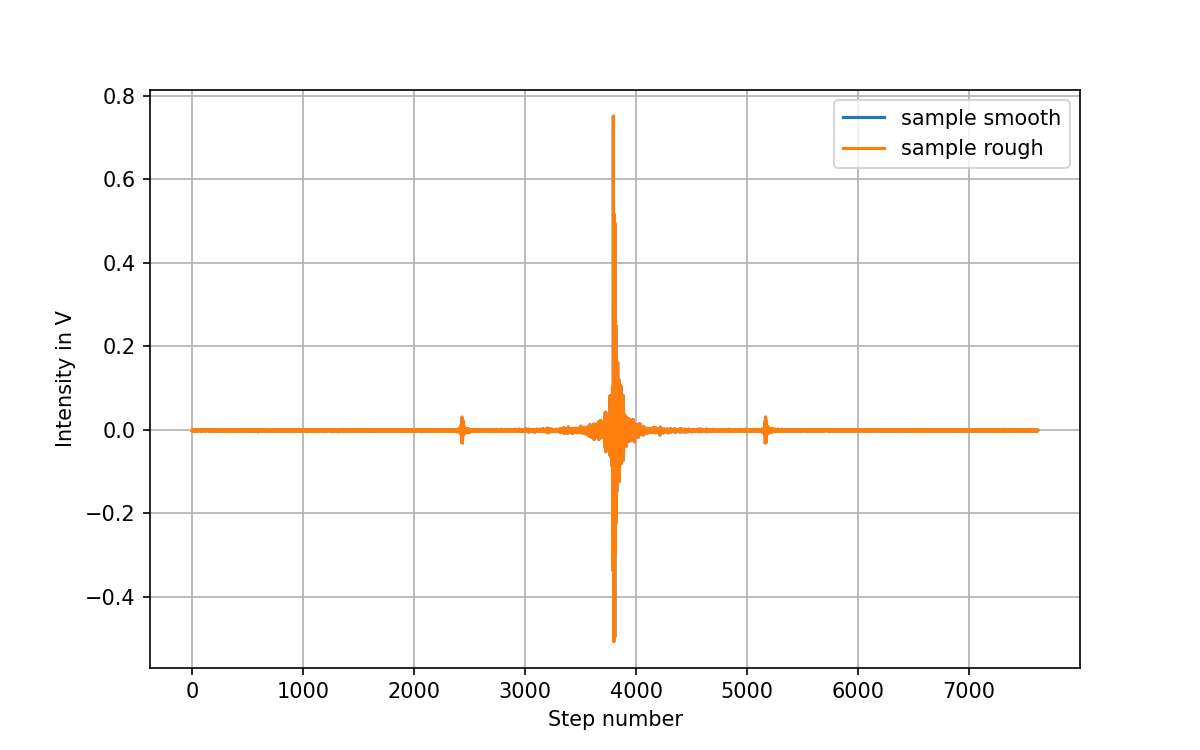

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


index_max apod:3796
index_max apod:3796
index_max apod:3795
index_max apod:3795


<IPython.core.display.Javascript object>


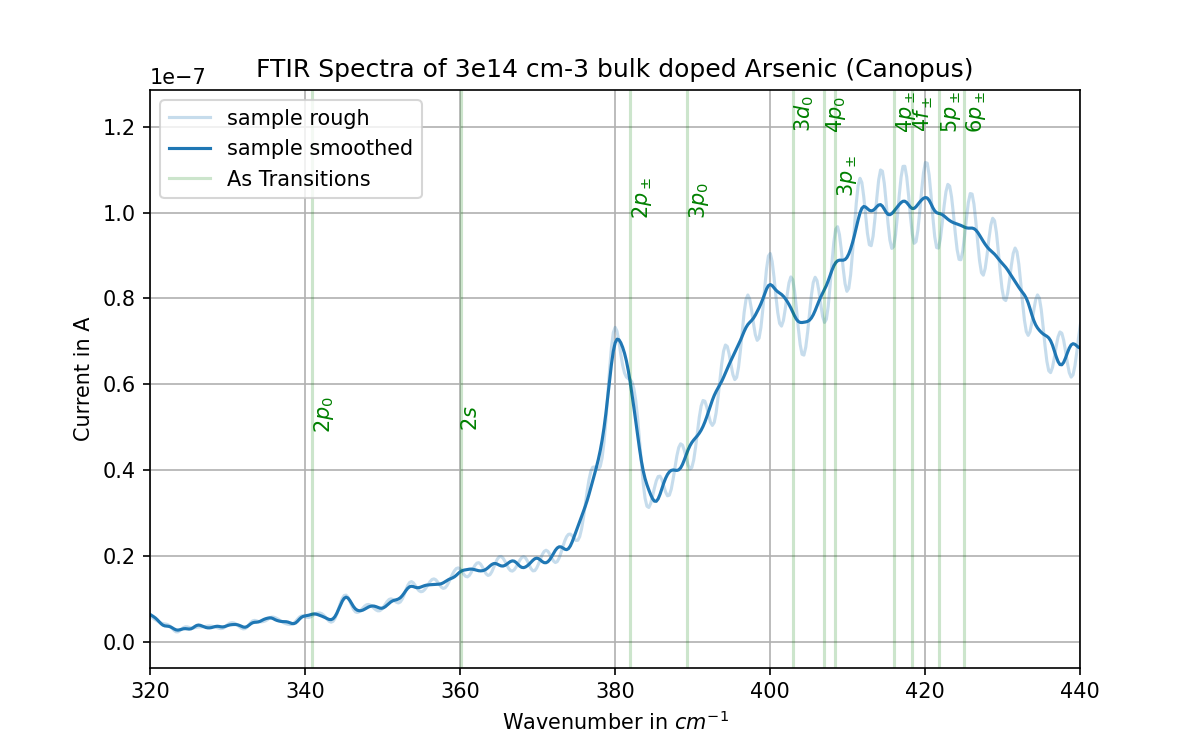

<IPython.core.display.Javascript object>


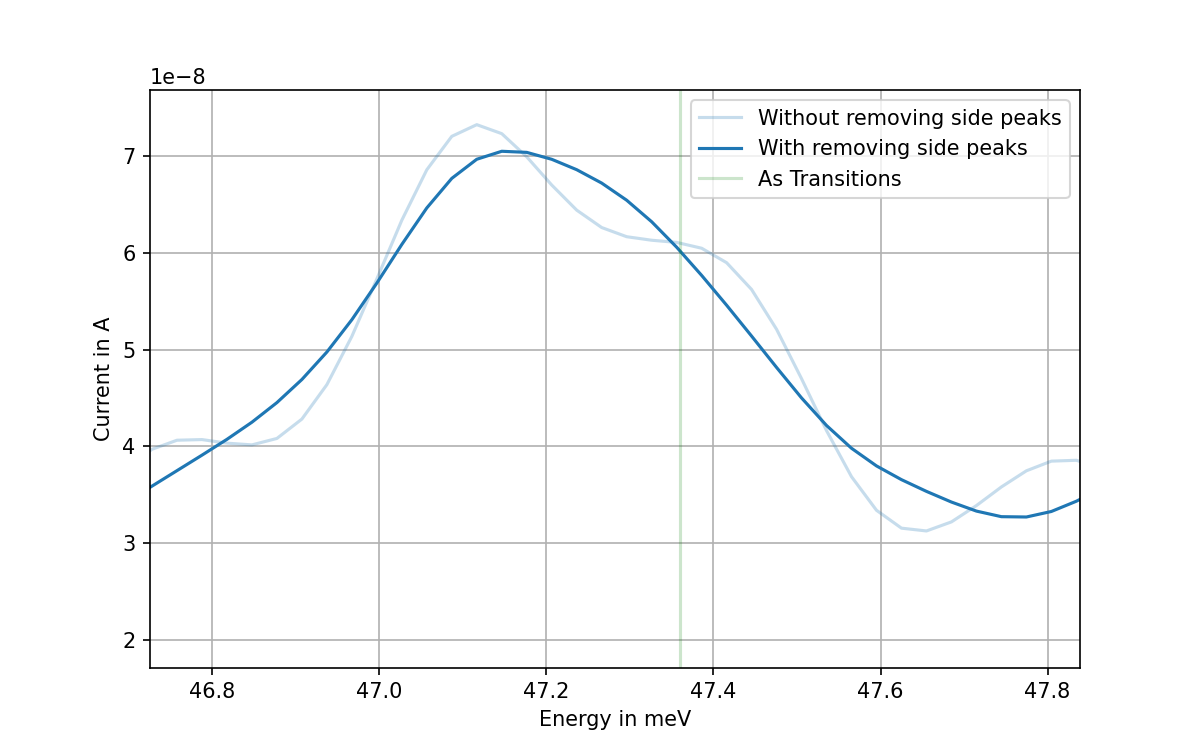

deleted old version of 2023-04-19-canopus_averaged_FT.txt
saved file 2023-04-19-canopus_averaged_FT.txt
deleted old version of 2023-04-19-canopus_averagedAndSmoothed_FT.txt
saved file 2023-04-19-canopus_averagedAndSmoothed_FT.txt
Cell compiled at 2023-06-13 14:22:16


In [2]:
if not ('postProcessedAverage' in locals()): 
    postProcessedAverage = pd.read_csv(pathDataSmoothed, sep="\t", header=None, names=["Step", "IFG Value"])
if not ('preProcessedAverage' in locals()):
    preProcessedAverage = pd.read_csv(pathDataAveraged, sep="\t", header=None, names=["Step", "IFG Value"])

forSampleSmooth, backSampleSmooth = ftFuncs.split_IFG_forwards_backwards(postProcessedAverage)
forSampleRough, backSampleRough = ftFuncs.split_IFG_forwards_backwards(preProcessedAverage)

saveFigTo = os.path.join(resultspath, "AllIFGs.png")
saveFigTo2 = os.path.join(resultspath, "AllIFGs.eps")

plt.figure(figsize=(8, 5))
plt.plot(backSampleSmooth["IFG Value"], label = 'sample smooth')
plt.plot(backSampleRough["IFG Value"], label = 'sample rough')
plt.legend()
plt.xlabel("Step number")
plt.ylabel("Intensity in V")
plt.savefig(saveFigTo)
plt.savefig(saveFigTo2)
plt.grid()
plt.show()

forSampleSmoothTrueSC, forSampleSmoothMagSC   = ftFuncs.single_sided_IFG_to_spectrum_full(forSampleSmooth,2 , 4)
forSampleRoughTrueSC, forSampleRoughMagSC     = ftFuncs.single_sided_IFG_to_spectrum_full(forSampleRough, 2, 4)
backSampleSmoothTrueSC, backSampleSmoothMagSC = ftFuncs.single_sided_IFG_to_spectrum_full(backSampleSmooth, 2, 4)
backSampleRoughTrueSC, backSampleRoughMagSC   = ftFuncs.single_sided_IFG_to_spectrum_full(backSampleRough, 2, 4)


finalSampleSmooth = forSampleSmoothMagSC
finalSampleSmooth["Spectrum"] += backSampleSmoothMagSC["Spectrum"]
finalSampleSmooth["Spectrum"] /= 2

finalSampleRough = forSampleRoughMagSC
finalSampleRough["Spectrum"] += backSampleRoughMagSC["Spectrum"]
finalSampleRough["Spectrum"] /= 2

################################################################################

sensitivity = 2e-8

saveFigTo = os.path.join(resultspath, "Spectrum.png")

plt.figure(figsize=(8, 5))
plt.plot(finalSampleRough["Wavenumbers"], finalSampleRough["Spectrum"]*sensitivity, c='tab:blue', label = 'sample rough', alpha = 0.25)
plt.plot(finalSampleSmooth["Wavenumbers"], finalSampleSmooth["Spectrum"]*sensitivity, c='tab:blue', label = 'sample smoothed')

plt.axvline(x=ftFuncs.wavenumber(42.26/1000), color='g', alpha=0.2, label='As Transitions')
plt.text(ftFuncs.wavenumber(42.26/1000),0.5e-7,'$2p_0$',color='g',rotation=90)
plt.axvline(x=ftFuncs.wavenumber(44.65/1000), c='g', alpha=0.2)
plt.text(ftFuncs.wavenumber(44.65/1000),0.5e-7,'$2s$',color='g',rotation=90)
plt.axvline(x=ftFuncs.wavenumber(47.36/1000), c='g', alpha=0.2)
plt.text(ftFuncs.wavenumber(47.36/1000),1e-7,'$2p_\pm$',color='g',rotation=90)
plt.axvline(x=ftFuncs.wavenumber(48.27/1000), c='g', alpha=0.2)
plt.text(ftFuncs.wavenumber(48.27/1000),1e-7,'$3p_0$',color='g',rotation=90)
plt.axvline(x=ftFuncs.wavenumber(49.96/1000), c='g', alpha=0.2)
plt.text(ftFuncs.wavenumber(49.96/1000),1.2e-7,'$3d_0$',color='g',rotation=90)
plt.axvline(x=ftFuncs.wavenumber(50.45/1000), c='g', alpha=0.2)
plt.text(ftFuncs.wavenumber(50.45/1000),1.2e-7,'$4p_0$',color='g',rotation=90)
plt.axvline(x=ftFuncs.wavenumber(50.64/1000), c='g', alpha=0.2)
plt.text(ftFuncs.wavenumber(50.64/1000),1.05e-7,'$3p_\pm$',color='g',rotation=90)
plt.axvline(x=ftFuncs.wavenumber(51.57/1000), c='g', alpha=0.2)
plt.text(ftFuncs.wavenumber(51.57/1000),1.2e-7,'$4p_\pm$',color='g',rotation=90)
plt.axvline(x=ftFuncs.wavenumber(51.86/1000), c='g', alpha=0.2)
plt.text(ftFuncs.wavenumber(51.86/1000),1.2e-7,'$4f_\pm$',color='g',rotation=90)
plt.axvline(x=ftFuncs.wavenumber(52.3/1000), c='g', alpha=0.2)
plt.text(ftFuncs.wavenumber(52.3/1000),1.2e-7,'$5p_\pm$',color='g',rotation=90)
plt.axvline(x=ftFuncs.wavenumber(52.69/1000), c='g', alpha=0.2)
plt.text(ftFuncs.wavenumber(52.69/1000),1.2e-7,'$6p_\pm$',color='g',rotation=90)
                  
plt.legend()
plt.xlim(320,440)
plt.title("FTIR Spectra of " + sampleName)
plt.xlabel("Wavenumber in $cm^{-1}$")
plt.ylabel("Current in A")
plt.grid()
plt.savefig(saveFigTo)
plt.show()

################################################################################

saveFigTo = os.path.join(resultspath, "SpectrumEnergy.png")

plt.figure(figsize=(8, 5))
plt.plot(ftFuncs.energy(finalSampleRough["Wavenumbers"])*1000, finalSampleRough["Spectrum"]*sensitivity, c='tab:blue', label = 'Without removing side peaks', alpha = 0.25)
plt.plot(ftFuncs.energy(finalSampleSmooth["Wavenumbers"])*1000, finalSampleSmooth["Spectrum"]*sensitivity, c='tab:blue', label = 'With removing side peaks')

plt.axvline(x=42.26, color='g', alpha=0.2, label='As Transitions')
plt.text(42.26,0.5e-7,'$2p_0$',color='g',rotation=90)
plt.axvline(x=44.65, c='g', alpha=0.2)
plt.text(44.65,0.5e-7,'$2s$',color='g',rotation=90)
plt.axvline(x=47.36, c='g', alpha=0.2)
plt.text(47.36,1e-7,'$2p_\pm$',color='g',rotation=90)
plt.axvline(x=48.27, c='g', alpha=0.2)
plt.text(48.27,1e-7,'$3p_0$',color='g',rotation=90)
plt.axvline(x=49.96, c='g', alpha=0.2)
plt.text(49.96,1.2e-7,'$3d_0$',color='g',rotation=90)
plt.axvline(x=50.45, c='g', alpha=0.2)
plt.text(50.45,1.2e-7,'$4p_0$',color='g',rotation=90)
plt.axvline(x=50.64, c='g', alpha=0.2)
plt.text(50.64,1.05e-7,'$3p_\pm$',color='g',rotation=90)
plt.axvline(x=51.57, c='g', alpha=0.2)
plt.text(51.57,1.2e-7,'$4p_\pm$',color='g',rotation=90)
plt.axvline(x=51.86, c='g', alpha=0.2)
plt.text(51.86,1.2e-7,'$4f_\pm$',color='g',rotation=90)
plt.axvline(x=52.30, c='g', alpha=0.2)
plt.text(52.30,1.2e-7,'$5p_\pm$',color='g',rotation=90)
plt.axvline(x=52.69, c='g', alpha=0.2)
plt.text(52.69,1.2e-7,'$6p_\pm$',color='g',rotation=90)
                  
plt.legend()
plt.xlim(40, 55)
#plt.title("FTIR Spectra of " + sampleName)
plt.xlabel("Energy in meV")
plt.ylabel("Current in A")
plt.grid()
plt.savefig(saveFigTo)
plt.show()


# saves all the fourier transformed data
paths = [pathDataRoughFt, pathDataSmoothFt]
names = [nameDataRoughFt, nameDataSmoothFt]
files = [finalSampleRough, finalSampleSmooth]

for i in range (2):#4):
    
    if os.path.isfile(paths[i]):
        os.remove(paths[i])
        print("deleted old version of " + names[i])   

    files[i].to_csv(paths[i], header=0, index=None, sep='\t', mode='a')
    print("saved file " + names[i])


print("Cell compiled at " + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

# Integrates Spectrum and compares to peak value of interferogram

In [12]:
filenames = ['postProcessedAverage', 'preProcessedAverage']
names = ["Sample post-processing", "Sample pre-processing"]
paths = [pathDataSmoothed, pathDataAveraged]

for i in range (len(filenames)):
    
    # gets interferogram
    if (filenames[i] in locals()): 
        IFG = locals()[filenames[i]].copy()
    else: 
        IFG = pd.read_csv(paths[i], sep="\t", header=None, names=["Step", "IFG Value"])
    
    # gets height of interferogram peak
    IFGfolded = ftFuncs.splitAndFold(IFG)
    peak = IFGfolded.max(axis='rows')["IFG Value"]
    # gets FFT of interferogram and calculates area using numerical quadrature
    area = ftFuncs.getArea(IFGfolded)
    
    print(names[i], ": IFG Peak value = ", peak, ", Spectrum integral = ", area)

print("Cell compiled at " + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

Sample post-processing : IFG Peak value =  0.5024342321428571 , Spectrum integral =  0.503440841903119
Sample pre-processing : IFG Peak value =  0.5024342321428571 , Spectrum integral =  0.5034408483898017
Cell compiled at 2023-06-09 16:00:48


C:\Users\theow\Anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
